# Table of Contents 

* Business Understanding
* Data Understanding
* Prepare Data
* Data Modeling
* Evaluate the Results

# Business Understanding

In April 15, 1912, the RMS Titanic sank traveling across the Altantic Ocean from Southampton, England, to New York City. In this Kaggle exercise, I'll be using the Titanic passenger dataset to determine what features highly correlate to passenger survival. The binary classification model approach is very relevant in the real world. Using algorithms like logistic regression we can isolate important features to determine success or failure. 

1. How many passenger classes did Titanic have and what was the median age in each class?
2. Were there more families or single passengers on the Titanic?
3. What is the one characteristic among the passengers that determined highest probability of survival?


# Data Understanding & Prepare Data

For data understanding and preparing the data for analysis, I conducted an analysis on the underlying data as well as imputing the data to better understand trends and patterns. This analysis can be viewed on this [blog post](https://towardsdatascience.com/kaggle-titanic-competition-in-sql-78ae3cd551ce). 

In the blog post, I analyzed missing values, correlation, and basic imputation technique in preparation for binary classification modeling. In addition to the deep dive analysis in the blog, I'll be analyzing the business questions asked above and highlight a few insights relevant to better understand the Titanic dataset.

In [41]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('titanic_data/data-train.csv')
test = pd.read_csv('titanic_data/data-test.csv')
data = train.append(test)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   survived                891 non-null    float64
 1   passengerid             1309 non-null   int64  
 2   title_surname_survival  1309 non-null   int64  
 3   pclass                  1309 non-null   int64  
 4   sex                     1309 non-null   int64  
 5   age                     1309 non-null   float64
 6   age_bucket              1309 non-null   int64  
 7   fare                    1309 non-null   float64
 8   fare_bucket             1309 non-null   int64  
 9   title_grouping          1309 non-null   int64  
 10  is_woman_boy            1309 non-null   int64  
 11  family_size             1309 non-null   int64  
 12  is_one_family           1309 non-null   int64  
 13  is_mix_group            1309 non-null   int64  
 14  is_alone                1309 non-null   i

In [92]:
train.head()

,survived,passengerid,title_surname_survival,pclass,sex,age,age_bucket,fare,fare_bucket,title_grouping,is_woman_boy,family_size,is_one_family,is_mix_group,is_alone,cabin_level,embarked
0,0,1,0,3,0,22.0,2,7.2500,0,3,0,2,0,0,1,6,0
1,1,2,0,1,1,38.0,3,71.2833,3,1,1,2,1,0,0,2,1
2,1,3,0,3,1,26.0,2,7.9250,0,2,1,1,0,0,1,6,0
3,1,4,0,1,1,35.0,3,53.1000,2,1,1,2,1,0,0,2,0
4,0,5,0,3,0,35.0,3,8.0500,0,3,0,1,0,0,1,6,0


#### 1. How many passenger classes did Titanic have and what was the median age in each class?

Using train data, I'm estimating the percentage of passengers in each class. There were three classes and first class was the most expensive. Although the third class tickets were the cheapest, all the cabins were very spacious and comfortable.

In [31]:
# using train, count of number of passengers in each class
pclass_agg = train.groupby('pclass')['passengerid'].count().reset_index() 
total_passengers = sum(pclass_agg['passengerid'])

# calculate the passenger percent of total for each class 
df_pclass_pct = pd.DataFrame(pclass_agg['passengerid'] / total_passengers).rename(columns={'passengerid':
                                                                                           'pclass_pct'})
pclass_agg = pclass_agg.join(df_pclass_pct)

pclass_agg.head()

,pclass,passengerid,pclass_pct
0,1,216,0.242424
1,2,184,0.206510
2,3,491,0.551066


Next, lets look at age. Initially, there were about 20% of the age values missing. In order to impute the age feature, I grouped the data by pclass, sex, and title_grouping to calculate each grouping's average age. I went with the mean rather than the median because both sets of numbers are similar. I also calculated the standard deviation of the mean to examine the variability.

Let's examine the following:
* Density plot per pclass
* Median age per pclass

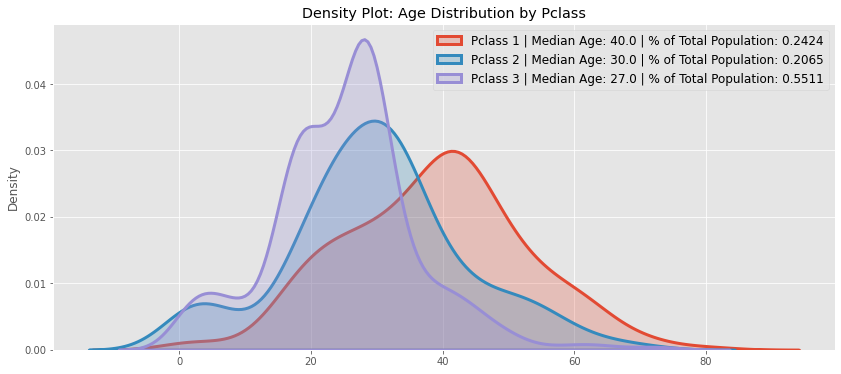

In [91]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))

for num in sorted(train.pclass.unique()):
    # calculate median age per class
    pclass_median_age = np.median(train[train.pclass==num].age)
    # calculate each class % passenger against total passengers in train data
    percent_of_population = round(pclass_agg[pclass_agg.pclass==num].pclass_pct.iloc[0], 4)
    # create density plot per class
    sns.distplot(train[train.pclass==num].age, 
                 hist = False, 
                 kde = True,
                 kde_kws = {'linewidth': 3, 'shade': True},
                 label = f'Pclass {num} | Median Age: {pclass_median_age} | % of Total Population: {percent_of_population}')

plt.legend(prop = {'size': 12})
plt.title('Density Plot: Age Distribution by Pclass')
plt.xlabel('')
plt.ylabel('Density');

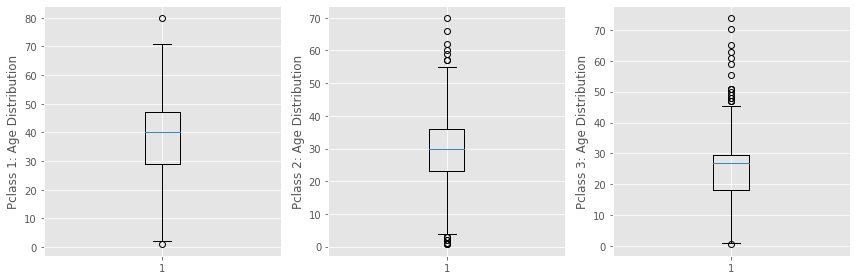

In [89]:
# let's make boxplots to visualise outliers in the continuous variables 
fig, _ = plt.subplots(1, 3, figsize=(12, 4))

cnt = 1
for ax in fig.axes:
    ax.set_ylabel(f"Pclass {cnt}: Age Distribution")
    ax.boxplot(train[train.pclass==cnt].age)
    cnt += 1
plt.tight_layout()

#### 2. Were there more families or single passengers on the Titanic?

To determine each passenger's family size, it’s logical to add SibSp, ParCh, and the current passenger (+1). However, rather than defining this at the passenger level, it made more sense to determine the maximum family size based on ticket number and surname.

I’m sticking with the assumption that families traveled together and, in this case, on the same ticket. As a result, the sum of SibSp, ParCh, and current passenger, which represents the family size, is matched with a ticket number and surname.

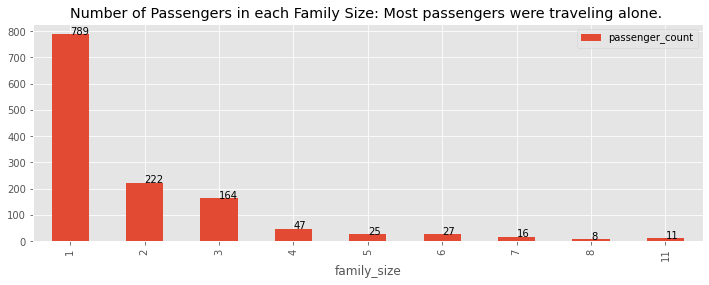

In [142]:
# create counts
df_fam_size = data.family_size.value_counts().reset_index().rename(columns={
    'index':'family_size', 'family_size':'passenger_count'})

df_fam_size = df_fam_size.sort_values(by=['family_size']).set_index('family_size')

# create bar plot
df_fam_size.plot.bar(figsize=(12,4))

# add text value to each bar
for idx, val in enumerate(df_fam_size.passenger_count.tolist()):
    plt.text(idx, val, str(val))

# add title
plt.title("Number of Passengers in each Family Size: Most passengers were traveling alone. ");


#### 3. What is the one characteristic among the passengers that determined highest probability of survival?

The most crucial trait a passenger could have is innate, but this trait pushes your probability of survival to 74.2%. It is being a woman passenger. It shows that as the ship started to sink the crew started to prioritize who would go into the lifeboats because there were not enought lifeboats to carry all passengers. As a baseline model, by using gender, you get quite high survival prediction. 

Another crucial trait that arises is that not all male passengers were created equal in this sinking scenario. Overall, you see that if you were a male passenger, your overall survival was about 18.9%. However, if you breakdown the male passenger population into adult and children bucket, it tells a very striking story. Back in the old days, boys often had the Master title until they were of older age. By carving out this subgroup using their titles, you see that boys had a survival rate of 57.5%.

As a result, if you were a woman or a child passenger, your probability of survival was very high. That is the big takeaway due to the fact that crew prioritized these passengers over all else. In addition, adding in pclass, age, and family size, you get a clearer picture of who had a higher chance of surviving the sinking.

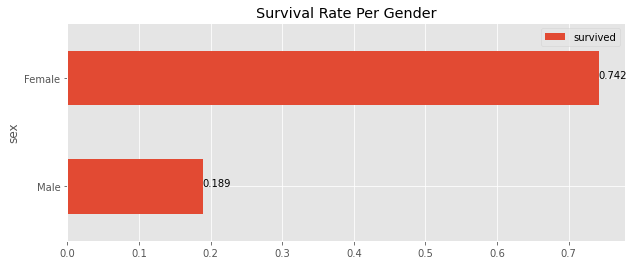

In [164]:
# Overall survival rate by gender (1=Female, 0=Male)
train.groupby('sex')['survived'].mean().rename(index={1:'Female', 0:'Male'}).plot.barh(figsize=(10,4))

for idx, val in enumerate(train.groupby('sex')['survived'].mean().tolist()):
    plt.text(val, idx, str(round(val, 3)))
plt.title("Survival Rate Per Gender")
plt.legend();

Text(0.5, 1.0, 'Survival Rate by Title Grouping')

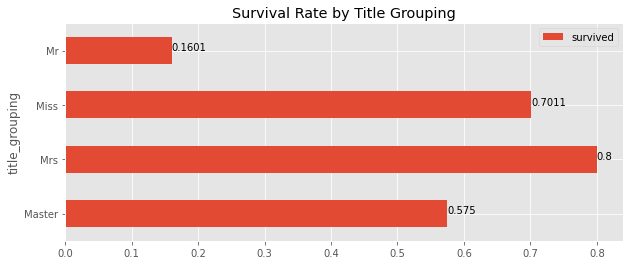

In [183]:
df_title_grouping = train.groupby('title_grouping')['survived'].mean().reset_index()
df_title_grouping.set_index('title_grouping').rename(index={
    0:'Master', 1:'Mrs', 2:'Miss', 3:'Mr'}).plot.barh(figsize=(10,4))

for idx, val in enumerate(df_title_grouping.survived.tolist()):
    plt.text(val, idx, str(round(val,4)))
plt.title("Survival Rate by Title Grouping")

# Data Modeling 
* Import Libraries
* Helper Functions
* Prepare Train & Test DFs
* All Model Runs
* Feature Selection with Random Forest Feature Importance - Trial & Error
* RandomizedSearchCV: Random Forest Classifier
* GridSearchCV: Random Forest Classifier
* Compare Random Forest RandomizedSearchCV and GridSearchCV
* Prepare Gender Submission File
* Optional: LinearSVC Pipeline & GridSearchCV

## Import Libraries

In [2]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score

## Helper Functions

In [332]:
def rf_feature_ranking(n, feature_importance_scores):
    """
    n (parameter 1): an integer; number of features in X_train
    feature_importance_scores (parameter 2): numpy ndarray from sklearn.ensemble.RandomForestClassifier.feature_importances_
    """
    
    feature_importances = {}
    for idx in range(n):
        key = X_train.columns[idx]
        val = feature_importance_scores[idx]
        feature_importances[key] = val

    df_feature_importances = pd.DataFrame.from_dict(feature_importances, orient='index', columns=['importance'])
    df_sorted = df_feature_importances.sort_values('importance', ascending=False)
    
    return df_sorted

In [138]:
# import pandas as pd
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import cross_val_predict
# from sklearn.metrics import precision_score, recall_score, roc_auc_score

# paramters: models (dict), X_train (dataframe, array), y_train (dataframe, array)
def output_model_stats(models, X_train, y_train):
    '''
     Function outputs these model metrics:
        'accuracy','accuracy_cv_score','accuracy_cv_stddev',
        'precision_score','recall_score','f1_score',
        'roc_auc_score (cross_val_score)','roc_auc_score (cross_val_predict)'
    '''
    
    model_stats = {}
    for mname, minst in models.items():
        model_scores = []

        # create pipeline with scaler and model instantiation steps
        model_pipe = make_pipeline(StandardScaler(), minst)

        # fit training data and run model score
        model_pipe.fit(X_train, y_train)
        model_scores.append(model_pipe.score(X_train, y_train))

        # implement cross validation model accuracy score
        scores = cross_val_score(model_pipe, X_train, y_train, cv=10, scoring='accuracy')
        model_scores.append(scores.mean())
        model_scores.append(scores.std())

        # implement cross validation predictions on training data
        y_train_cv_pred = cross_val_predict(model_pipe, X_train, y_train, cv=10)

        # calculate precision and recall
        p = precision_score(y_train, y_train_cv_pred)
        r = recall_score(y_train, y_train_cv_pred)
        model_scores.append(p)
        model_scores.append(r)

        # calculate F1 score
        f1_score = 2*(p*r)/(p+r)
        model_scores.append(f1_score)

        # calculate ROC AUC score using cross_val_score
        roc_auc_cvs = cross_val_score(model_pipe, X_train, y_train, cv=10, scoring='roc_auc').mean()
        model_scores.append(roc_auc_cvs)

        # create dictionary key/pair value
        model_stats[mname] = model_scores
    
    colnames = ['accuracy','accuracy_cv_score','accuracy_cv_stddev',
                'precision_score','recall_score','f1_score',
                'roc_auc_score (cross_val_score)']

    # put model stats into a dataframe
    df_model_stats = pd.DataFrame.from_dict(model_stats, orient='index', columns=colnames)
    df_model_stats_ranked = df_model_stats.sort_values(by='accuracy', ascending=False)

    # output is a dataframe
    return df_model_stats_ranked

## Prepare Train & Test DFs

In [3]:
train_df = pd.read_csv('titanic_data/data-train.csv')
test_df = pd.read_csv('titanic_data/data-test.csv')

train_df = train_df.rename(columns={"is_woman_boy": "is_woman_child"})
test_df = test_df.rename(columns={"is_woman_boy": "is_woman_child"})

In [4]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   survived                891 non-null    int64  
 1   passengerid             891 non-null    int64  
 2   title_surname_survival  891 non-null    int64  
 3   pclass                  891 non-null    int64  
 4   sex                     891 non-null    int64  
 5   age                     891 non-null    float64
 6   age_bucket              891 non-null    int64  
 7   fare                    891 non-null    float64
 8   fare_bucket             891 non-null    int64  
 9   title_grouping          891 non-null    int64  
 10  is_woman_child          891 non-null    int64  
 11  family_size             891 non-null    int64  
 12  is_one_family           891 non-null    int64  
 13  is_mix_group            891 non-null    int64  
 14  is_alone                891 non-null    in

In [5]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   passengerid             418 non-null    int64  
 1   title_surname_survival  418 non-null    int64  
 2   pclass                  418 non-null    int64  
 3   sex                     418 non-null    int64  
 4   age                     418 non-null    float64
 5   age_bucket              418 non-null    int64  
 6   fare                    418 non-null    float64
 7   fare_bucket             418 non-null    int64  
 8   title_grouping          418 non-null    int64  
 9   is_woman_child          418 non-null    int64  
 10  family_size             418 non-null    int64  
 11  is_one_family           418 non-null    int64  
 12  is_mix_group            418 non-null    int64  
 13  is_alone                418 non-null    int64  
 14  cabin_level             418 non-null    in

In [6]:
train_df['survived']
np.array(features['TARGET'].astype(np.int32)).reshape((-1, ))

,survived,passengerid,title_surname_survival,pclass,sex,age,age_bucket,fare,fare_bucket,title_grouping,is_woman_child,family_size,is_one_family,is_mix_group,is_alone,cabin_level,embarked
0,0,1,0,3,0,22.0,2,7.2500,0,3,0,2,0,0,1,6,0
1,1,2,0,1,1,38.0,3,71.2833,3,1,1,2,1,0,0,2,1
2,1,3,0,3,1,26.0,2,7.9250,0,2,1,1,0,0,1,6,0
3,1,4,0,1,1,35.0,3,53.1000,2,1,1,2,1,0,0,2,0
4,0,5,0,3,0,35.0,3,8.0500,0,3,0,1,0,0,1,6,0


In [4]:
for i,j in enumerate(train_df):
    print(i,j)

0 survived
1 passengerid
2 title_surname_survival
3 pclass
4 sex
5 age
6 age_bucket
7 fare
8 fare_bucket
9 title_grouping
10 is_woman_child
11 family_size
12 is_one_family
13 is_mix_group
14 is_alone
15 cabin_level
16 embarked


In [4]:
# check to see if any of the columns are object types
[var for var in train_df if train_df[var].dtypes == 'O']

[]

In [5]:
[var for var in train_df if train_df[var].dtypes != 'O']

['survived',
 'passengerid',
 'title_surname_survival',
 'pclass',
 'sex',
 'age',
 'age_bucket',
 'fare',
 'fare_bucket',
 'title_grouping',
 'is_woman_child',
 'family_size',
 'is_one_family',
 'is_mix_group',
 'is_alone',
 'cabin_level',
 'embarked']

In [901]:
train_df.dtypes

survived                    int64
passengerid                 int64
title_surname_survival      int64
pclass                      int64
sex                         int64
age                       float64
age_bucket                  int64
fare                      float64
fare_bucket                 int64
title_grouping              int64
is_woman_child              int64
family_size                 int64
is_one_family               int64
is_mix_group                int64
is_alone                    int64
cabin_level                 int64
embarked                    int64
dtype: object

In [458]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   survived                891 non-null    int64  
 1   passengerid             891 non-null    int64  
 2   title_surname_survival  891 non-null    int64  
 3   pclass                  891 non-null    int64  
 4   sex                     891 non-null    int64  
 5   age                     891 non-null    float64
 6   age_bucket              891 non-null    int64  
 7   fare                    891 non-null    float64
 8   fare_bucket             891 non-null    int64  
 9   title_grouping          891 non-null    int64  
 10  is_woman_child          891 non-null    int64  
 11  family_size             891 non-null    int64  
 12  is_one_family           891 non-null    int64  
 13  is_mix_group            891 non-null    int64  
 14  is_alone                891 non-null    in

In [459]:
train_df.shape

(891, 17)

In [460]:
train_df.head()

,survived,passengerid,title_surname_survival,pclass,sex,age,age_bucket,fare,fare_bucket,title_grouping,is_woman_child,family_size,is_one_family,is_mix_group,is_alone,cabin_level,embarked
0,0,1,0,3,0,22.0,2,7.2500,0,3,0,2,0,0,1,6,0
1,1,2,0,1,1,38.0,3,71.2833,3,1,1,2,1,0,0,2,1
2,1,3,0,3,1,26.0,2,7.9250,0,2,1,1,0,0,1,6,0
3,1,4,0,1,1,35.0,3,53.1000,2,1,1,2,1,0,0,2,0
4,0,5,0,3,0,35.0,3,8.0500,0,3,0,1,0,0,1,6,0


In [798]:
train_df['fare_bucket'].value_counts().sort_index(axis=0)

0    571
1    114
2    121
3     54
4     23
5      8
Name: fare_bucket, dtype: int64

## Correlation Coefficient Matrix - What features are correlated?

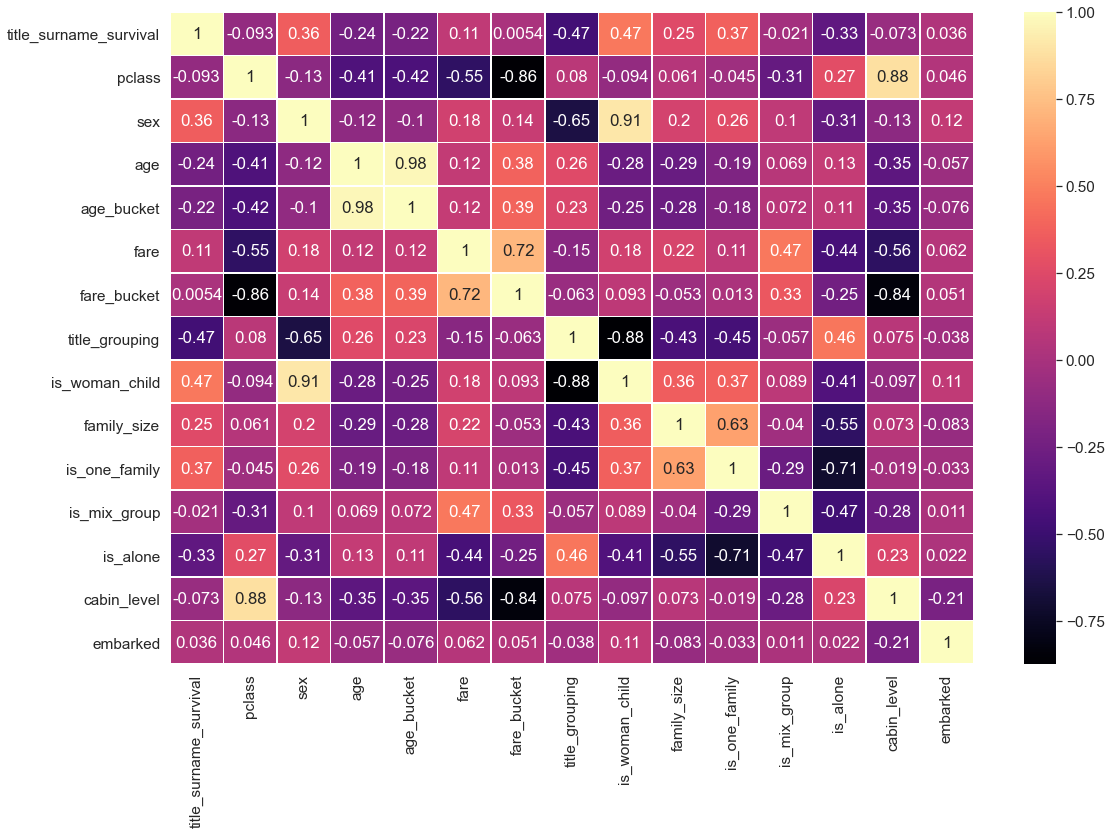

In [172]:
train_corr = train_df.drop(columns=["survived", "passengerid"]).corr(method='pearson')
plt.figure(figsize=(18, 12))
sns.set(font_scale=1.4)
sns.heatmap(train_corr, annot=True, linecolor='white', linewidth=0.5, cmap='magma');

In [173]:
# Pearson's correlation analysis using an arbitrary correlation threshold (absolute values)
corr_threshold = 0.8
train_corr_abs = train_corr.abs()

feature_1 = []
feature_2 = []
corr_coeff = []
for col in train_corr_abs:
    for idx, val in enumerate(train_corr_abs[col]):
        if ((val >= corr_threshold) and (val < 1)):
            feature_1.append(col)
            feature_2.append(train_corr_abs[col].index[idx])
            corr_coeff.append(val)


df_corr = pd.DataFrame({'feature_1': feature_1, 
                        'feature_2': feature_2, 
                        'corr_coeff': corr_coeff})
df_corr

,feature_1,feature_2,corr_coeff
0,pclass,fare_bucket,0.862865
1,pclass,cabin_level,0.880487
2,sex,is_woman_child,0.908578
3,age,age_bucket,0.977768
4,age_bucket,age,0.977768
5,fare_bucket,pclass,0.862865
6,fare_bucket,cabin_level,0.835361
7,title_grouping,is_woman_child,0.875224
8,is_woman_child,sex,0.908578
9,is_woman_child,title_grouping,0.875224


In [169]:
# removed duplicate correlated pairs manually for Pearson
df_corr.drop([5, 10, 8, 4, 11, 9])

,feature_1,feature_2,corr_coeff
0,pclass,fare_bucket,0.862865
1,pclass,cabin_level,0.880487
2,sex,is_woman_child,0.908578
3,age,age_bucket,0.977768
6,fare_bucket,cabin_level,0.835361
7,title_grouping,is_woman_child,0.875224


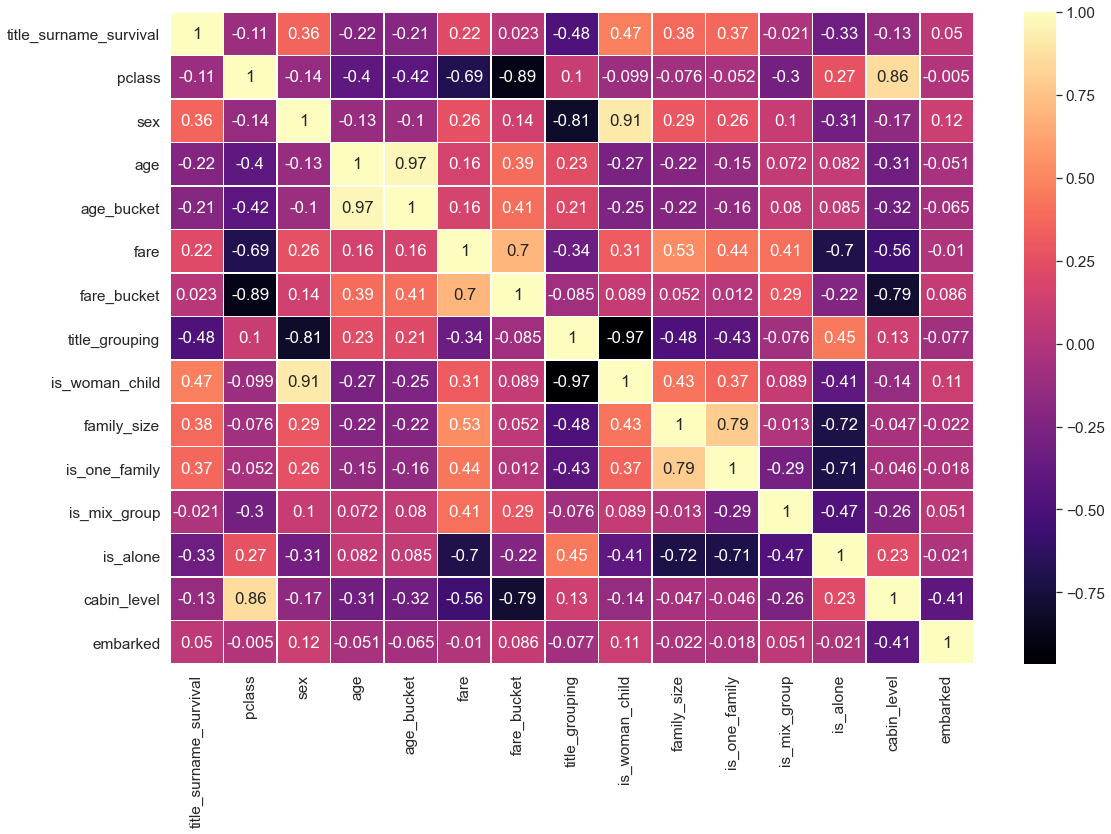

In [164]:
train_corr = train_df.drop(columns=["survived", "passengerid"]).corr(method='spearman')
plt.figure(figsize=(18, 12))
sns.set(font_scale=1.4)
sns.heatmap(train_corr, annot=True, linecolor='white', linewidths=0.5, cmap='magma')

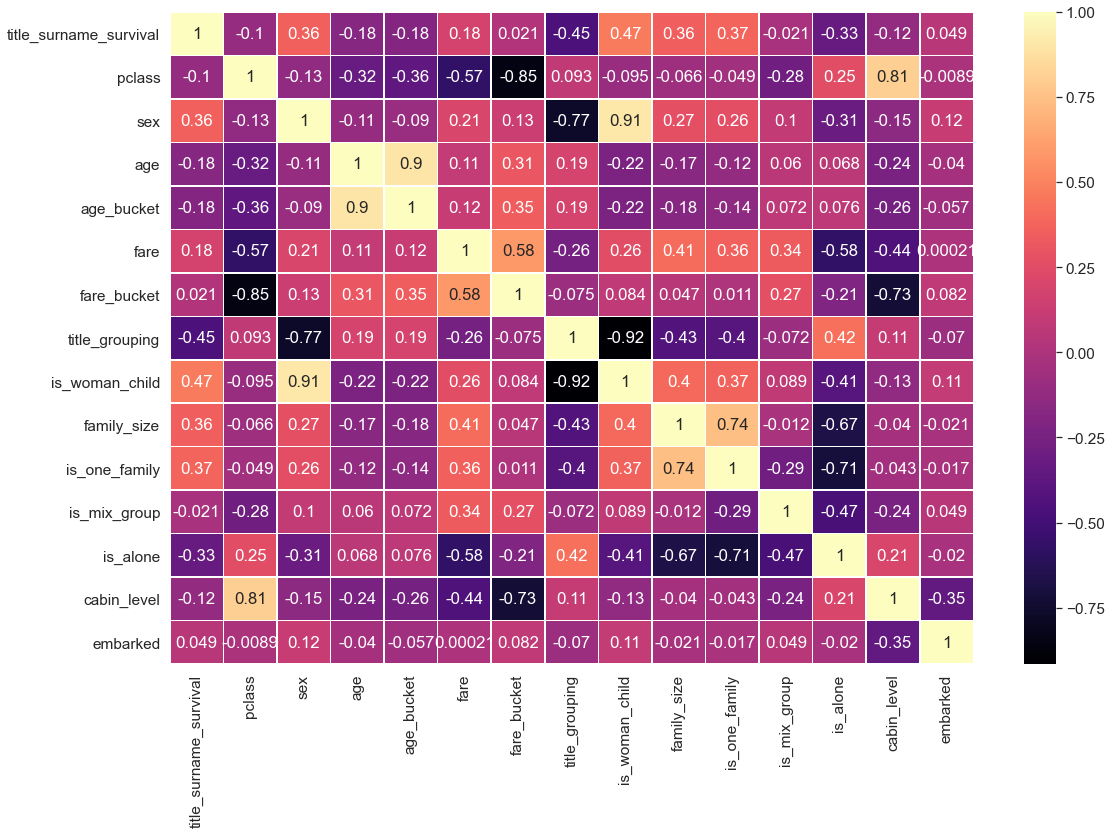

In [165]:
train_corr = train_df.drop(columns=["survived", "passengerid"]).corr(method='kendall')
plt.figure(figsize=(18, 12))
sns.set(font_scale=1.4)
sns.heatmap(train_corr, annot=True, linecolor='white', linewidths=0.5, cmap='magma')

## Testing Association Using Cramers V

In [217]:
train_df_c = train_df.drop(["survived","passengerid","age","fare","family_size"], axis=1)

In [218]:
train_df_c.head()
# 7 mutli-label ordinal and nominal features

,title_surname_survival,pclass,sex,age_bucket,fare_bucket,title_grouping,is_woman_boy,is_one_family,is_mix_group,is_alone,cabin_level,embarked
0,0,3,0,2,0,3,0,0,0,1,6,0
1,0,1,1,3,3,1,1,1,0,0,2,1
2,0,3,1,2,0,2,1,0,0,1,6,0
3,0,1,1,3,2,1,1,1,0,0,2,0
4,0,3,0,3,0,3,0,0,0,1,6,0


In [221]:
import pandas as pd
import numpy as np
import scipy.stats as ss

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [222]:
cramers_v(train_df_c["embarked"], train_df_c["title_grouping"])

0.1326036659660891

## Prepare X_train, X_test, and y_train

In [599]:
# remove pclass, sex, fare, age, is_one_family
y_train = train_df["survived"]

X_train = train_df.drop(["survived",
                         "passengerid"], axis=1)

X_test = test_df.drop(["passengerid"], axis=1)

In [89]:
"""
# final X_train and X_test
X_train = train_df.drop(["survived",
                         "passengerid",
                         "age_bucket",
                         "fare_bucket",
                         "is_mix_group",
                         "age",
                         "fare",
                         "is_one_family",
                         "embarked",
                         "is_alone",
                         "family_size"
                        ], axis=1)

y_train = train_df["survived"]

X_test = test_df.drop(["passengerid",
                       "age_bucket",
                       "fare_bucket",
                       "is_mix_group",
                       "age",
                       "fare",
                       "is_one_family",
                       "embarked",
                       "is_alone",
                       "family_size"
                      ], axis=1)
"""

In [444]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   title_surname_survival  891 non-null    int64
 1   age_bucket              891 non-null    int64
 2   fare_bucket             891 non-null    int64
 3   title_grouping          891 non-null    int64
 4   is_woman_boy            891 non-null    int64
 5   family_size             891 non-null    int64
 6   is_mix_group            891 non-null    int64
 7   is_alone                891 non-null    int64
 8   cabin_level             891 non-null    int64
 9   embarked                891 non-null    int64
dtypes: int64(10)
memory usage: 69.7 KB


In [101]:
X_test.head()

,title_surname_survival,pclass,sex,title_grouping,is_woman_boy,cabin_level
0,0,2,0,3,0,5
1,0,3,1,1,1,6
2,0,1,1,2,1,1
3,0,3,0,3,0,5
4,0,3,1,2,1,5


# Evaluate the Results

## All Model Runs

In [600]:
# random_state=0 for reproducibility
models = {'LogisticRegression': LogisticRegression(random_state=0),
          'SupportVectorMachines': SVC(random_state=0),
          'RandomForest': RandomForestClassifier(random_state=0),
          'KNN': KNeighborsClassifier(n_neighbors=5),
          'GaussianNaiveBayes': GaussianNB(),
          'Perceptron': Perceptron(random_state=0),
          'LinearSVC': LinearSVC(dual=False, random_state=0),
          'StochasticGradientDescent': SGDClassifier(random_state=0),
          'DecisionTree': DecisionTreeClassifier(random_state=0)}

df_all_models = output_model_stats(models, X_train, y_train)

df_all_models

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
RandomForest,0.985410,0.840662,0.042127,0.816456,0.754386,0.784195,0.878338
DecisionTree,0.985410,0.813683,0.035645,0.758824,0.754386,0.756598,0.799605
KNN,0.882155,0.846230,0.040249,0.842809,0.736842,0.786271,0.884104
SupportVectorMachines,0.863075,0.852971,0.037761,0.904215,0.690058,0.782753,0.885039
LogisticRegression,0.856341,0.847378,0.038261,0.841060,0.742690,0.788820,0.888919
LinearSVC,0.852974,0.851848,0.038544,0.854730,0.739766,0.793103,0.888811
StochasticGradientDescent,0.849607,0.824994,0.040406,0.790625,0.739766,0.764350,0.863675
GaussianNaiveBayes,0.797980,0.792472,0.051915,0.766102,0.660819,0.709576,0.857032
Perceptron,0.632997,0.778976,0.083369,0.721713,0.690058,0.705531,0.830623


In [ ]:
'''
# calculate ROC AUC score using cross_val_predict

# decision_func_models = ['SupportVectorMachines','Perceptron','LinearSVC','StochasticGradientDescent']
predict_proba_models = ['LogisticRegression','RandomForest','KNN','GaussianNaiveBayes','DecisionTree']

if mname in predict_proba_models:
    y_train_probas = cross_val_predict(model_pipe, X_train, y_train, method='predict_proba')
    y_train_probas = y_train_probas[:, 1]
else:
    y_train_probas = cross_val_predict(model_pipe, X_train, y_train, method='decision_function')

roc_auc_cvp = roc_auc_score(y_train, y_train_probas)
model_scores.append(roc_auc_cvp)
'''

## Feature Selection with Random Forest Feature Importance - Trial & Error

In [489]:
model = {"rf_base - iteration 1": RandomForestClassifier(random_state=0)}
df_rf_base = output_model_stats(model, X_train, y_train)
df_iteration_1 = df_rf_base.append(df_all_models.loc["RandomForest"])
df_iteration_1

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
rf_base - iteration 1,0.921437,0.835056,0.044777,0.832765,0.713450,0.768504,0.887743
RandomForest,0.985410,0.840662,0.042127,0.816456,0.754386,0.784195,0.878338


In [771]:
rf_base = RandomForestClassifier(n_estimators=100, random_state=0)
rf_base.fit(X_train, y_train)

n = len(X_train.columns)
importance_scores = rf_base.feature_importances_
rf_feature_ranking(n, importance_scores)

,importance
title_grouping,0.295244
is_woman_child,0.218054
pclass,0.191324
title_surname_survival,0.162235
family_size,0.133143


In [549]:
rf_base = RandomForestClassifier(n_estimators=100, random_state=0)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

rf_base.score(X_train, y_train)

0.8552188552188552

In [524]:
y_train_base_pred = rf_base.predict(X_train)

# output is a reflection of overfitting the model
confusion_matrix(y_train, y_train_base_pred)

array([[521,  28],
       [ 91, 251]])

In [525]:
rf_base.feature_importances_

array([0.1953357 , 0.4549489 , 0.12695335, 0.22276204])

## RF Feature Selection: Permutation Importance vs Feature Importance

In [468]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

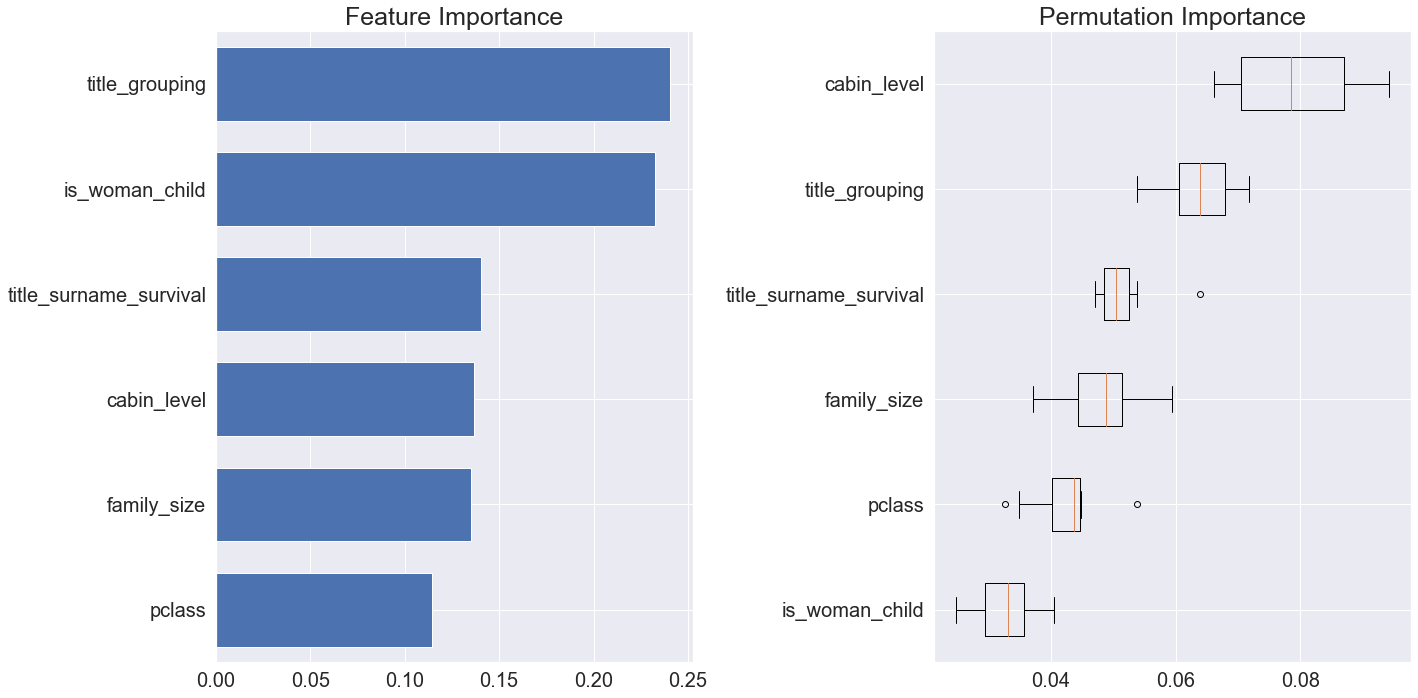

In [867]:
X_train = train_df.drop(["survived",
                         "passengerid",
                         "age",
                         "fare",
                         "is_alone",
                         "is_mix_group",
                         "is_one_family",
                         "sex",
                         "embarked",
                         "fare_bucket",
                         "age_bucket"
                        ], axis=1)

y_train = train_df["survived"]

X_test = test_df.drop(["passengerid",
                         "age",
                         "fare",
                         "is_alone",
                         "is_mix_group",
                         "is_one_family",
                         "sex",
                         "embarked",
                         "fare_bucket",
                         "age_bucket"
                      ], axis=1)

clf = RandomForestClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

result = permutation_importance(clf, X_train, y_train, n_repeats=10, random_state=0)
perm_sorted_idx = result.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(clf.feature_importances_)
tree_indices = np.arange(0, len(clf.feature_importances_)) + 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.barh(tree_indices, clf.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_yticklabels(X_train.columns[tree_importance_sorted_idx])
ax1.set_yticks(tree_indices)
ax1.set_ylim((0, len(clf.feature_importances_)))
ax1.tick_params(labelsize=20)
ax1.set_title('Feature Importance', fontsize=25)

ax2.boxplot(result.importances[perm_sorted_idx].T, vert=False,
            labels=X_train.columns[perm_sorted_idx])
ax2.set_title('Permutation Importance', fontsize=25)
ax2.tick_params(labelsize=20)

fig.tight_layout()
plt.show()

In [868]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   title_surname_survival  891 non-null    int64
 1   pclass                  891 non-null    int64
 2   title_grouping          891 non-null    int64
 3   is_woman_child          891 non-null    int64
 4   family_size             891 non-null    int64
 5   cabin_level             891 non-null    int64
dtypes: int64(6)
memory usage: 41.9 KB


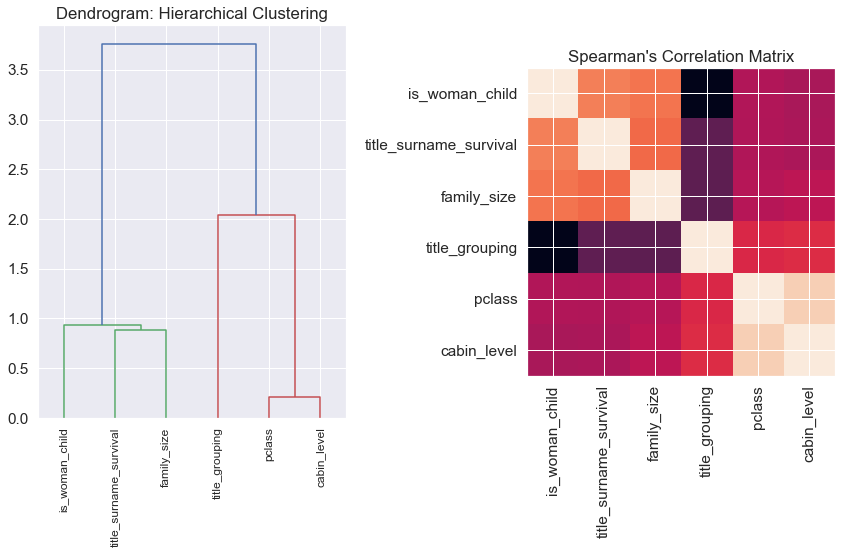

In [869]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X_train).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X_train.columns, ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax1.set_title('Dendrogram: Hierarchical Clustering')

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
ax2.set_title("Spearman's Correlation Matrix")
fig.tight_layout()
plt.show()

In [780]:
"""
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')

cluster_id_to_feature_ids = defaultdict(list)

for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
    
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

X_train_sel = X_train.iloc[:, selected_features]
X_test_sel = X_test.iloc[:, selected_features]

clf_sel = RandomForestClassifier(n_estimators=100, random_state=0)
clf_sel.fit(X_train_sel, y_train)

# print("Accuracy on test data with features removed: {:.2f}".format(
#     clf_sel.score(X_test_sel, y_test)))
"""

'\ncluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion=\'distance\')\n\ncluster_id_to_feature_ids = defaultdict(list)\n\nfor idx, cluster_id in enumerate(cluster_ids):\n    cluster_id_to_feature_ids[cluster_id].append(idx)\n    \nselected_features = [v[0] for v in cluster_id_to_feature_ids.values()]\n\nX_train_sel = X_train.iloc[:, selected_features]\nX_test_sel = X_test.iloc[:, selected_features]\n\nclf_sel = RandomForestClassifier(n_estimators=100, random_state=0)\nclf_sel.fit(X_train_sel, y_train)\n\n# print("Accuracy on test data with features removed: {:.2f}".format(\n#     clf_sel.score(X_test_sel, y_test)))\n'

In [829]:
X_train.head()

,title_surname_survival,pclass,title_grouping,is_woman_child,family_size,cabin_level
0,0,3,3,0,2,6
1,0,1,1,1,2,2
2,0,3,2,1,1,6
3,0,1,1,1,2,2
4,0,3,3,0,1,6


In [605]:
model = {"rf_base - iteration 2": RandomForestClassifier(n_estimators=100, random_state=0)}

df_iteration_2 = output_model_stats(model, X_train, y_train)
df_iteration_2 = df_iteration_2.append(df_all_models.loc['RandomForest'])
df_iteration_2

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
rf_base - iteration 1,0.914703,0.838439,0.042414,0.836735,0.719298,0.773585,0.873840
RandomForest,0.985410,0.840662,0.042127,0.816456,0.754386,0.784195,0.878338


In [843]:
df_iteration_2 = df_iteration_1.rename(index={'rf_base - iteration 1': 'rf_base - iteration 2'})
df_iteration_2

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
rf_base - iteration 2,0.914703,0.838439,0.042414,0.836735,0.719298,0.773585,0.873840
RandomForest,0.985410,0.840662,0.042127,0.816456,0.754386,0.784195,0.878338


In [856]:
model = {"rf_base - iteration 3": RandomForestClassifier(n_estimators=100, random_state=0)}

df_iteration_3 = output_model_stats(model, X_train, y_train)
df_iteration_3 = df_iteration_3.append(df_iteration_2)
df_iteration_3

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
rf_base - iteration 3,0.868687,0.845156,0.046112,0.861702,0.710526,0.778846,0.891742
rf_base - iteration 2,0.914703,0.838439,0.042414,0.836735,0.719298,0.773585,0.873840
RandomForest,0.985410,0.840662,0.042127,0.816456,0.754386,0.784195,0.878338


## RandomizedSearchCV: Random Forest Classifier

In [882]:
rf = RandomForestClassifier(random_state=0)
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [870]:
# param_distributions
rs_grid = {'criterion': ['gini', 'entropy'],
         'n_estimators': [100, 300, 500, 800, 1000, 1200, 1400],
         'max_features': ['auto', 'log2'],
         'max_depth': [3, 5, 7, 9, 15, 25, 30],
         'min_samples_split': [2, 3, 4, 5, 7, 10, 15],
         'min_samples_leaf': [1, 2, 5, 10, 12, 14]}


# create base model to tune
rf = RandomForestClassifier(random_state=0)

# randomized search of parameters using 3 fold cross validation, 
rf_rsearch = RandomizedSearchCV(estimator=rf, 
                               param_distributions=rs_grid, 
                               n_iter=200, 
                               cv=5, 
                               verbose=3, 
                               random_state=0, 
                               n_jobs=-1)

# fit model
rf_rsearch.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  4.9min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [885]:
rf_rsearch.best_params_

{'n_estimators': 500,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 5,
 'criterion': 'gini'}

In [872]:
# define our optimal random forest model
best_rfrs = rf_rsearch.best_estimator_

# fit X_train, y_train using best randomizedsearch estimator
best_rfrs.fit(X_train, y_train)

# make y predictions for X_test
y_pred_rfrs = best_rfrs.predict(X_test)

# calculate accuruacy using train data
print('accuracy:', best_rfrs.score(X_train, y_train))

accuracy: 0.856341189674523


In [873]:
# cross validation score
best_rfrs_scores = cross_val_score(best_rfrs, X_train, y_train, cv=10, scoring='accuracy')
print("")
print("accuracy:", best_rfrs_scores.mean())
print("standard deviation:", best_rfrs_scores.std())


accuracy: 0.8563171036204744
standard deviation: 0.04083051522970345


In [874]:
print("")
print("RandomizedSearchCV: Improvement from initial base model Random Forest CV k_fold=10:")
print("")
print("------> ", best_rfrs_scores.mean() - df_all_models.loc['RandomForest']['accuracy_cv_score'])
print("")


RandomizedSearchCV: Improvement from initial base model Random Forest CV k_fold=10:

------>  0.015655430711610463



In [875]:
n = len(X_train.columns)
importance_scores = best_rfrs.feature_importances_
rf_feature_ranking(n, importance_scores)

,importance
is_woman_child,0.277109
title_grouping,0.264449
title_surname_survival,0.143529
cabin_level,0.132028
pclass,0.116208
family_size,0.066677


In [884]:
# define our optimal random forest model
best_rfrs = rf_rsearch.best_estimator_

# create model dict variable for output_model_stats function
model = {"rf_randomized_search": best_rfrs}

df_rfrs = output_model_stats(model, X_train, y_train)
df_rfrs = df_rfrs.append(df_iteration_3)
df_rfrs

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
rf_randomized_search,0.856341,0.856317,0.040831,0.914729,0.690058,0.786667,0.890537
rf_base - iteration 3,0.868687,0.845156,0.046112,0.861702,0.710526,0.778846,0.891742
rf_base - iteration 2,0.914703,0.838439,0.042414,0.836735,0.719298,0.773585,0.873840
RandomForest,0.985410,0.840662,0.042127,0.816456,0.754386,0.784195,0.878338


## GridSearchCV: Random Forest Classifier

In [886]:
# instantiate base random forest model class
rf = RandomForestClassifier(random_state=0)

# define gridsearch parameters
param_grid = {'criterion': ['gini', 'entropy'],
              'n_estimators': [300, 500, 700],
              'max_features': ['auto', 'log2'],
              'max_depth': [3, 5, 7],
              'min_samples_split': [8, 10, 12],
              'min_samples_leaf': [8, 10, 12]}

# instantiate gridsearchcv class
rfgs = GridSearchCV(estimator=rf,
                    param_grid=param_grid,
                    cv=5,
                    verbose=3,
                    n_jobs=-1)

# fit model
rfgs.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   24.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed:  5.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [887]:
# output best hyperparameters
rfgs.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 8,
 'n_estimators': 300}

In [888]:
# define our optimal random forest model
best_rfgs = rfgs.best_estimator_

# fit the model to the training set
best_rfgs.fit(X_train, y_train)

# make y predictions for X_test with best gridsearch estimator
y_pred_best_rfgs = rfgs.predict(X_test)

# calculate accuracy score
print('accuracy:', best_rfgs.score(X_train, y_train))

accuracy: 0.856341189674523


In [889]:
# cross-validation
best_rfgs_scores = cross_val_score(best_rfgs, X_train, y_train, cv=10)
print("")
print("accuracy:", best_rfgs_scores.mean())
print("standard deviation:", best_rfgs_scores.std())


accuracy: 0.8563171036204744
standard deviation: 0.04083051522970345


In [890]:
print("")
print("GridSearchCV: Improvement from initial base model Random Forest CV k_fold=10:")
print("")
print("------> ", best_rfgs_scores.mean() - df_model_stats.loc['RandomForest']['accuracy_cv_score'])
print("")


GridSearchCV: Improvement from initial base model Random Forest CV k_fold=10:

------>  0.007827715355805287



In [891]:
n = len(X_train.columns)
best_rfgs_importance_scores = best_rfgs.feature_importances_
rf_feature_ranking(n, best_rfgs_importance_scores) 

,importance
is_woman_child,0.282970
title_grouping,0.267371
title_surname_survival,0.134255
cabin_level,0.133134
pclass,0.113789
family_size,0.068481


In [893]:
# define our optimal random forest model
best_rfgs = rfgs.best_estimator_

# create model dict variable for output_model_stats function
model = {"rf_grid_search": best_rfgs}

df_rfgs = output_model_stats(model, X_train, y_train)
df_rfgs = df_rfgs.append(df_rfrs)
df_rfgs

,accuracy,accuracy_cv_score,accuracy_cv_stddev,precision_score,recall_score,f1_score,roc_auc_score (cross_val_score)
rf_grid_search,0.856341,0.856317,0.040831,0.914729,0.690058,0.786667,0.890698
rf_randomized_search,0.856341,0.856317,0.040831,0.914729,0.690058,0.786667,0.890537
rf_base - iteration 3,0.868687,0.845156,0.046112,0.861702,0.710526,0.778846,0.891742
rf_base - iteration 2,0.914703,0.838439,0.042414,0.836735,0.719298,0.773585,0.873840
RandomForest,0.985410,0.840662,0.042127,0.816456,0.754386,0.784195,0.878338


## Prepare Gender Submission File

In [831]:
rf_base = RandomForestClassifier(n_estimators=100, random_state=0)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

rf_base.score(X_train, y_train)

0.8686868686868687

In [894]:
y_pred_df = pd.DataFrame(y_pred_best_rfgs, columns=['Survived'])
y_pred_df.head()

,Survived
0,0
1,0
2,1
3,0
4,1


In [895]:
df_output = pd.concat([test_df['passengerid'], y_pred_df], axis=1, sort=False)
df_output.head()

,passengerid,Survived
0,1269,0
1,1091,0
2,951,1
3,1075,0
4,1108,1


In [896]:
df_output = df_output.rename(columns={"passengerid": "PassengerId"})
df_output.to_csv('dlee_gender_submission.csv', index=False)
df_output.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   PassengerId  418 non-null    int64
 1   Survived     418 non-null    int64
dtypes: int64(2)
memory usage: 6.7 KB


In [897]:
rf_base = RandomForestClassifier(n_estimators=100, random_state=0)
rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)

df_output = pd.concat([test_df['passengerid'], y_pred_df], axis=1, sort=False)
df_output = df_output.rename(columns={"passengerid": "PassengerId"})
df_output.to_csv('dlee_gender_submission.csv', index=False)

In [898]:
X_train.head()

,title_surname_survival,pclass,title_grouping,is_woman_child,family_size,cabin_level
0,0,3,3,0,2,6
1,0,1,1,1,2,2
2,0,3,2,1,1,6
3,0,1,1,1,2,2
4,0,3,3,0,1,6


## Optional: LinearSVC Pipeline & GridSearchCV

In [128]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


SVCpipe = Pipeline([('scale', StandardScaler()),
                   ('SVC', LinearSVC(dual=False))])

# Gridsearch to determine the value of C
param_grid = {'SVC__C': np.arange(0.01,100,10)}

linearSVC = GridSearchCV(SVCpipe, param_grid, cv=10, return_train_score=True)

linearSVC.fit(X_train, y_train)

print(linearSVC.best_params_)
print("")
# linearSVC.coef_
# linearSVC.intercept_

bestlinearSVC = linearSVC.best_estimator_

bestlinearSVC.fit(X_train, y_train)

bestlinearSVC.coef_ = bestlinearSVC.named_steps['SVC'].coef_

print(bestlinearSVC.score(X_train,y_train))
print("")

cv_scores = cross_val_score(bestlinearSVC, X_train, y_train, cv=10)
print(cv_scores)
print("")
print(cv_scores.mean())
print("")
print(cv_scores.std())
print("")

# implement cross validation predictions on training data
y_train_pred = cross_val_predict(bestlinearSVC, X_train, y_train, cv=10, scoring='accuracy')
    
print("Precision:", precision_score(y_train, y_train_pred))
print("Recall:", recall_score(y_train, y_train_pred))

y_test_pred = bestlinearSVC.predict(X_test)

{'SVC__C': 10.01}

0.8496071829405163

[0.85555556 0.86516854 0.79775281 0.91011236 0.87640449 0.80898876
 0.82022472 0.79775281 0.8988764  0.86516854]

0.8496004993757804

0.039009050405649184
Precision: 0.8489932885906041
Recall: 0.7397660818713451


In [129]:
bestlinearSVC

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('SVC',
                 LinearSVC(C=10.01, class_weight=None, dual=False,
                           fit_intercept=True, intercept_scaling=1,
                           loss='squared_hinge', max_iter=1000,
                           multi_class='ovr', penalty='l2', random_state=None,
                           tol=0.0001, verbose=0))],
         verbose=False)